In [1]:
#The Dateset i have used in my project is LUSC which contains the read counts of each gene in sample
#mapped against genome. the columns in dataset represents the gene expressions of gene ids except 
#last column that contains samples label i.e cancerous vs non cancerous. 


In [2]:
#importing required libraries and modules 
import pandas as pd
import sklearn
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from prettytable import PrettyTable
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

In [3]:
#loading the file to dataframe usinf pandas read_csv() function and finding the shape of dataframe 
df=pd.read_csv("C:/Users/fc/Desktop/LUSC_MERGED.csv")
df.shape

(553, 23372)

In [4]:
#printing first five rows of file
df.head()

,Unnamed: 0,Unnamed: 0.1,Sample.name,1/2-SBSRNA4,A1BG,A1BG-AS1,A1CF,A2LD1,A2M,A2ML1,...,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,tAKR,SAMPLE
0,0,0,LUSC,11,1118,87,5,242,12680,257,...,259,500,606,17,1383,2747,417,1047,0,cancerous
1,1,1,LUSC,23,107,29,5,339,26591,3365,...,231,650,2945,66,1979,10117,1631,2226,9,cancerous
2,2,2,LUSC,77,2,8,1,338,27803,360,...,273,627,1742,28,1174,1050,1123,1389,64,cancerous
3,3,3,LUSC,29,360,46,3,168,54525,7,...,524,1165,2304,4,2484,9581,1758,2160,1,cancerous
4,4,4,LUSC,40,811,141,3,594,12343,3186,...,294,596,2983,572,2042,8921,2088,2514,72,cancerous


In [5]:
from sklearn.preprocessing import StandardScaler
def standardization(X):
    sc= StandardScaler()
# Standardizing the features
    x = StandardScaler().fit_transform(X)
    return x
    

In [6]:
#pca to reduce number of features for dataset visualization
from sklearn.decomposition import PCA
def PCA_function(df,x,Title):
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(x)
    principalDf = pd.DataFrame(data = principalComponents, columns = ['c1', 'c2'])
    finalDf = pd.concat([principalDf, df['SAMPLE']], axis = 1)
    
    #PCA Visualization
    fig = plt.figure(figsize = (6,6))
    ax = fig.add_subplot(1,1,1) 
    ax.set_title(Title, fontsize = 20)
    targets = ['cancerous', 'non-cancerous']
    colors = ['r', 'b']
    for target, color in zip(targets,colors):
        indicesToKeep = finalDf['SAMPLE'] == target
        ax.scatter(finalDf.loc[indicesToKeep, 'c1'], finalDf.loc[indicesToKeep, 'c2'], c = color)
    ax.legend(targets)
    ax.grid()

In [7]:
#function for counting cancerous and non cancerous samples
def barplott(df,Title):
    plt.figure(figsize=(6,6))
    plt.title(Title)
    plt.xlabel("LUSC")
    sns.set_theme(style="darkgrid")
    sns.countplot(x='SAMPLE',data=df)
    plt.show()

In [8]:
#counting cancerous and  non cancerous samples in dataset
print(df['SAMPLE'].value_counts())

cancerous        502
non-cancerous     51
Name: SAMPLE, dtype: int64


In [9]:
#selecting the number of features and target values and storing it in X,Y
X=df.iloc[:,3:23371].values 
Y=df.iloc[:,-1].values
print(type(X))

<class 'numpy.ndarray'>


In [10]:
#class is imbalance so we will use smote algorithm for class balance
from imblearn.over_sampling import SMOTE 
sm=SMOTE(random_state=0,sampling_strategy='minority')
x,y=sm.fit_resample(X,Y)

In [11]:
#converting smote datasets to dataframe
df_smote = pd.concat([pd.DataFrame(x), pd.DataFrame(y, columns=['SAMPLE'])], axis=1)
X_smote=df_smote.iloc[:,3:23367].values 
Y_smote=df_smote.iloc[:,-1].values

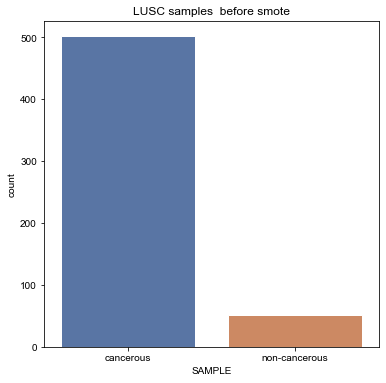

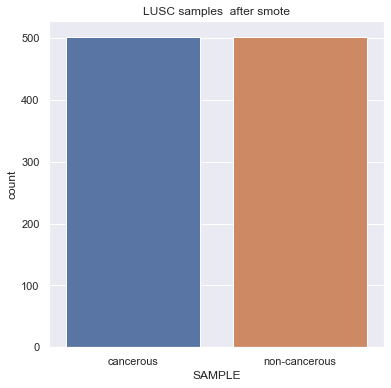

In [12]:
#counting cancerous and  non cancerous samples in dataset
barplott(df,"LUSC samples  before smote")
barplott(df_smote,"LUSC samples  after smote")

In [13]:
#standardizing the values of dataset before and after smote
X=standardization(X)
X_smote=standardization(X_smote)

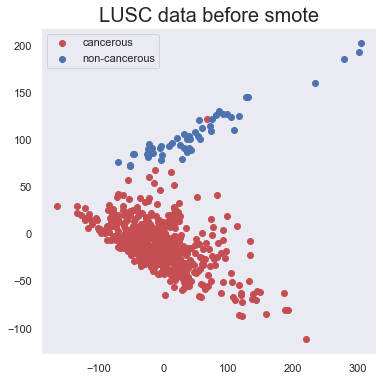

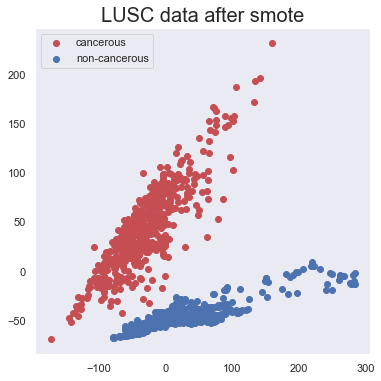

In [14]:
PCA_function(df,X,"LUSC data before smote")
PCA_function(df_smote,X_smote,"LUSC data after smote")

In [14]:
#after preprocessing and visualization of data, we will split the data into training and testing datasets
from sklearn.model_selection import train_test_split
# spliting the dataset before smote 
x_train, x_test ,y_train, y_test = train_test_split(X,Y,test_size =0.25, random_state=0)
#spliting the dataset after smote
X_train, X_test ,Y_train, Y_test = train_test_split(X_smote,Y_smote,test_size =0.25, random_state=0)


In [15]:
#standardization of training and testing dataset before smote
sc= StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
#after smote
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [16]:
#table to store scores before and applying smote algorithms
table1=PrettyTable()
table1.add_column("   ",
["TPR","TNR","FPR","FNR","Accuracy","precision","recall","F1_score"])
#storing scores after smote algorithms
table2=PrettyTable()
table2.add_column("   ",
["TPR","TNR","FPR","FNR","Accuracy","precision","recall","F1_score"])

In [17]:
#list storing values before and after smote
models=[]
accuracy=[]
precision=[]
recall=[]
F1=[]

#list storing values after optimization
models1=[]
accuracy1=[]
precision1=[]
recall1=[]
F11=[]

In [18]:
def CM_statistics(cnf_matrix,Y_test,model_name,prediction,table,accuracy,precision,recall,F1,models):
#calculating TP,FN,TP,TN
    FP = cnf_matrix[1][0]
    FN = cnf_matrix[0][1]
    TP = cnf_matrix[0][0]
    TN = cnf_matrix[1][1]
    
    total=FP+FN+TP+TN
    TPR=(TP/total)*100
    TNR=(TN/total)*100
    FNR=(FN/total)*100
    FPR=(FP/total)*100

#ACCURACY
    Accuracy = (accuracy_score(Y_test,prediction))*100
    Accuracy=round(Accuracy,2)
    accuracy.append(Accuracy)
    
#precision
    precision_macro= (precision_score(Y_test,prediction,average="weighted"))*100
    precision_macro=round(precision_macro,2)
    precision.append(precision_macro)
    

#Recall
    recall_macro= (recall_score(Y_test,prediction,average="weighted"))*100
    recall_macro=round(recall_macro,2)
    recall.append(recall_macro)
#F1_score
    F1_macro=(f1_score(Y_test,prediction,average="weighted"))*100
    F1_macro=round(F1_macro,2)
    F1.append(F1_macro)
    models.append(model_name)
   
    
#adding values to table 
    table.add_column(model_name,
[round(TPR,2),round(TNR,2),round(FPR,2),round(FNR,2),Accuracy,precision_macro,recall_macro,F1_macro])

In [19]:
#generating confusion matrix
def CONFUSION_MATRIX(model,X_train,Y_train,X_test,Y_test,model_name,table,accuracy,precision,recall,F1,Models,titlee):
    model.fit(X_train,Y_train)
    prediction = model.predict(X_test)
    Accuracy = accuracy_score(Y_test,prediction)
    print(Accuracy)
    #GENERATING CONFUSION MATRIX 
    cm = confusion_matrix(Y_test,prediction)
    CM_statistics(cm,Y_test,model_name,prediction,table,accuracy,precision,recall,F1,Models)
    matrix= plot_confusion_matrix(model,X_test,Y_test,cmap=plt.cm.Blues)
    matrix.ax_.set_title(model_name+' Confusion Matrix (LUSC)'+titlee,color='black')
    plt.xlabel('predicted label',color='black')
    plt.ylabel('true label',color='black')
    plt.gcf().axes[0].tick_params(color='white')
    plt.gcf().axes[1].tick_params(color='white')
    plt.gcf().set_size_inches(10,6)
    plt.show()
    

In [20]:
#method for randomized search for hyperparameter tuning
def Randomizedhyp(model,search_space):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    search = RandomizedSearchCV(model,param_distributions=search_space,n_iter=10,random_state=0,scoring='accuracy', cv=cv)
# execute search
    result = search.fit(X_train,Y_train)
# summarize result
    print('Best Score:   ',result.best_score_)
    print('Best Hyperparameters:  ',result.best_params_)

In [21]:
#method for grid search for hyperparameter tuning
def GRIDhyp(model,search_space):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    search = GridSearchCV(model,param_grid=search_space,scoring='accuracy', cv=cv)
# execute search
    result = search.fit(X_train,Y_train)
# summarize result
    print('Best Score:   ',result.best_score_)
    print('Best Hyperparameters:  ',result.best_params_)

In [22]:
from yellowbrick.classifier import ClassificationReport
def classification_report(model,X_train, Y_train,X_test, Y_test):
    visualizer =ClassificationReport(model, target_names=["cancerous","non_cancerous"])
    visualizer.fit(X_train, Y_train)        # Fit the visualizer and the model
    visualizer.score(X_test, Y_test)        # Evaluate the model on the test data
    visualizer.show()   

0.9784172661870504


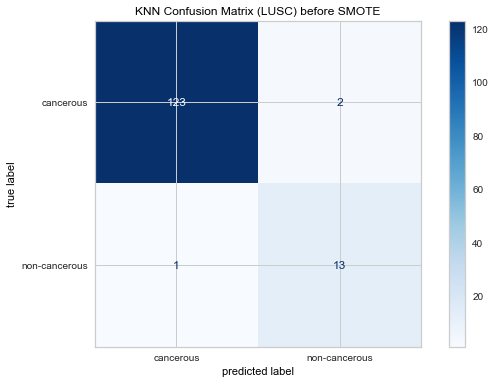

In [24]:
#TRAINING MODEL ON
from sklearn.neighbors import KNeighborsClassifier
KNN_model = KNeighborsClassifier()
# Train the model using the training sets
CONFUSION_MATRIX(KNN_model,x_train,y_train,x_test,y_test,"KNN",table1,accuracy,precision,recall,F1,models,' before SMOTE')

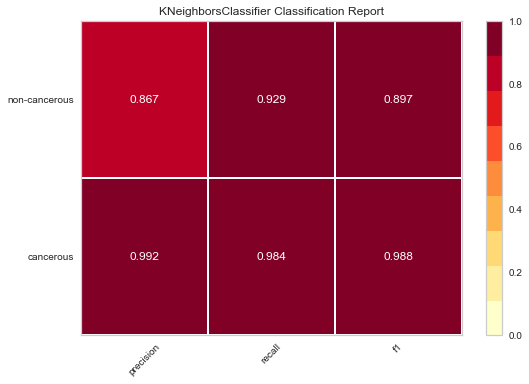

In [25]:
classification_report(KNN_model,x_train, y_train,x_test, y_test)

In [26]:
#training the model and finding accuracy ,if model 
model = KNeighborsClassifier()
model.fit(X_train,Y_train)
prediction = model.predict(X_test)
print(accuracy_score(Y_test,prediction))

0.896414342629482


0.9920318725099602


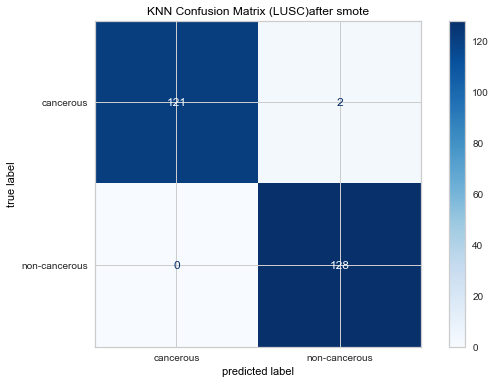

In [27]:
KNN_model = KNeighborsClassifier(n_neighbors=6,metric='minkowski',p=1)
# Train the model using the training sets
CONFUSION_MATRIX(KNN_model,X_train,Y_train,X_test,Y_test,"KNN",table2,accuracy1,precision1,recall1,F11,models1,"after smote")

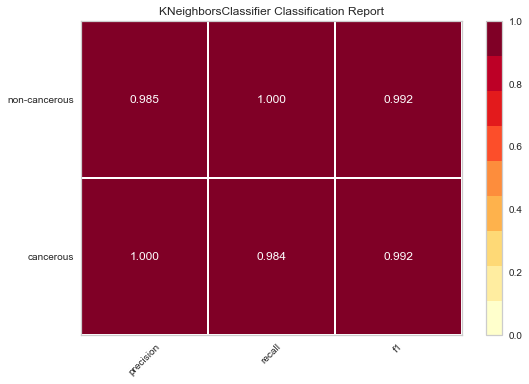

In [28]:
classification_report(KNN_model,X_train, Y_train,X_test, Y_test)

C:\Users\fc\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8776978417266187


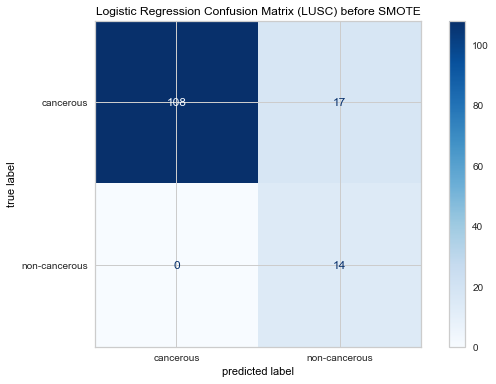

In [29]:
#LOGISTIC REGRESSION before hyperparameter tuning
from sklearn.linear_model import LogisticRegression
log = LogisticRegression()
CONFUSION_MATRIX(log,x_train,y_train,x_test,y_test,"Logistic Regression",table1,accuracy,precision,recall,F1,models,' before SMOTE')

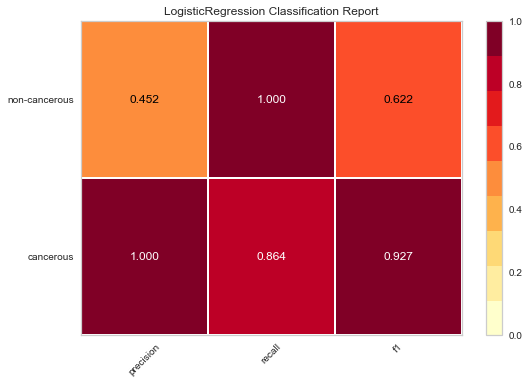

In [30]:
classification_report(log,x_train,y_train,x_test,y_test)

0.9482071713147411


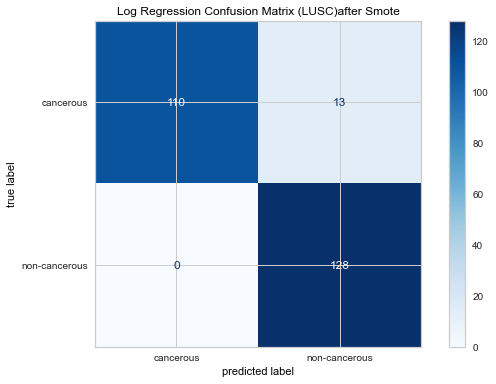

In [31]:
log = LogisticRegression()
CONFUSION_MATRIX(log,X_train,Y_train,X_test,Y_test,"Log Regression",table2,accuracy1,precision1,recall1,F11,models1,'after Smote')

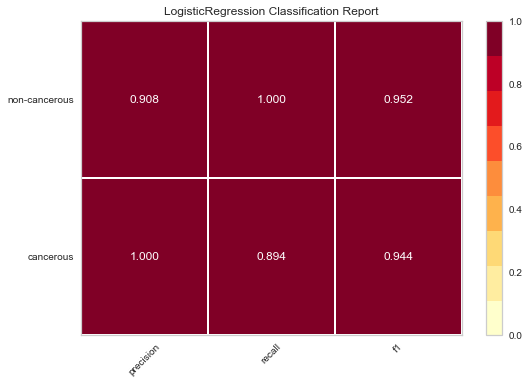

In [32]:
classification_report(log,X_train,Y_train,X_test,Y_test)

1.0


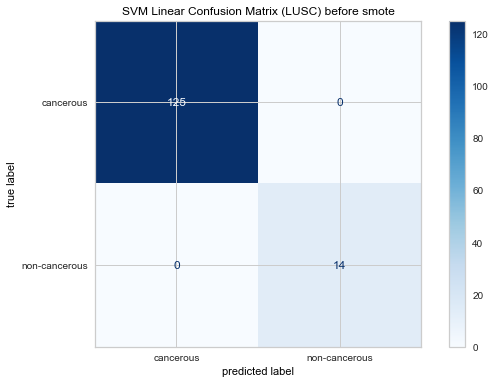

In [33]:
#SVC_linear after smote
from sklearn.svm import SVC
# Training a SVM classifier using SVC class
svm = SVC(kernel= 'linear', random_state=0)
CONFUSION_MATRIX(svm,x_train,y_train,x_test,y_test,"SVM Linear",table1,accuracy,precision,recall,F1,models,' before smote')



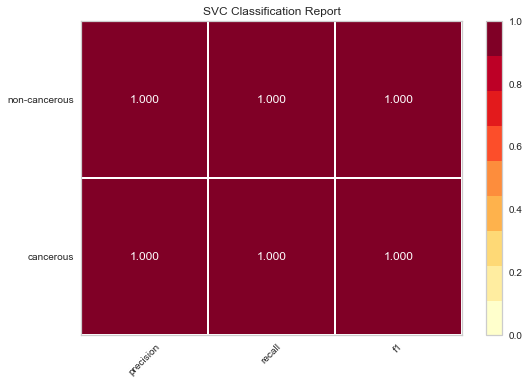

In [34]:
classification_report(svm,x_train, y_train,x_test, y_test)

1.0


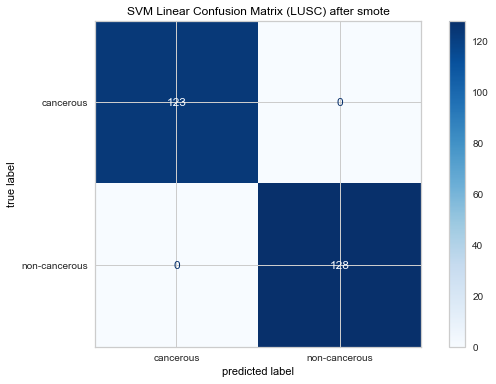

In [35]:
#SVC_linear AFTER smote
from sklearn.svm import SVC
# Training a SVM classifier using SVC class
svm = SVC(kernel= 'linear', random_state=0)
CONFUSION_MATRIX(svm,X_train,Y_train,X_test,Y_test,"SVM Linear",table2,accuracy1,precision1,recall1,F11,models1,' after smote')



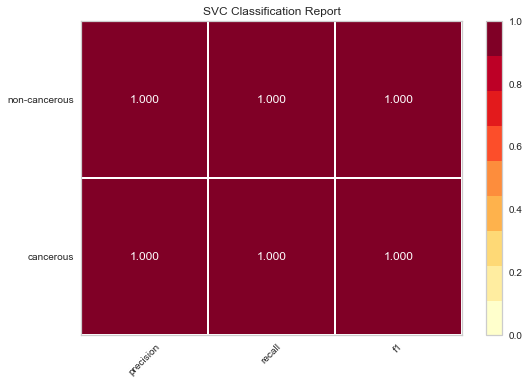

In [36]:
classification_report(svm,X_train, Y_train,X_test, Y_test)

0.9784172661870504


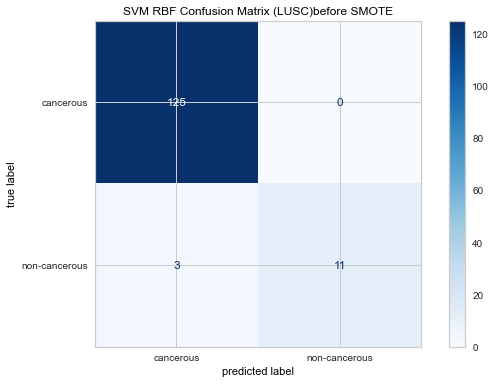

In [37]:
#SVC_linear before hyperparameter tuning
from sklearn.svm import SVC
# Training a SVM classifier using SVC class
svm = SVC(kernel= 'rbf', random_state=0)
CONFUSION_MATRIX(svm,x_train,y_train,x_test,y_test,"SVM RBF",table1,accuracy,precision,recall,F1,models,'before SMOTE')

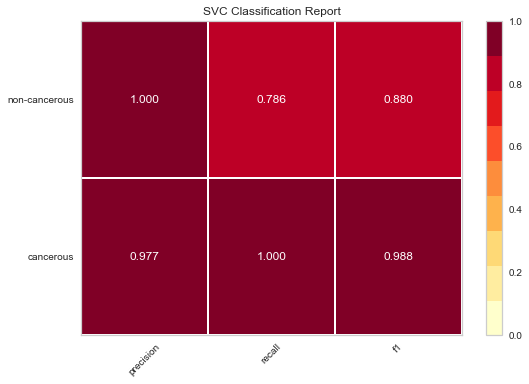

In [38]:
classification_report(svm,x_train, y_train,x_test, y_test)

1.0


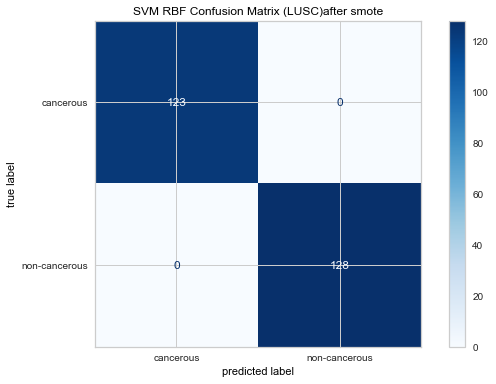

In [39]:
#SVC_linear without smote
from sklearn.svm import SVC
# Training a SVM classifier using SVC class
svm = SVC(kernel= 'rbf', random_state=0)
CONFUSION_MATRIX(svm,X_train,Y_train,X_test,Y_test,"SVM RBF",table2,accuracy1,precision1,recall1,F11,models1,'after smote')

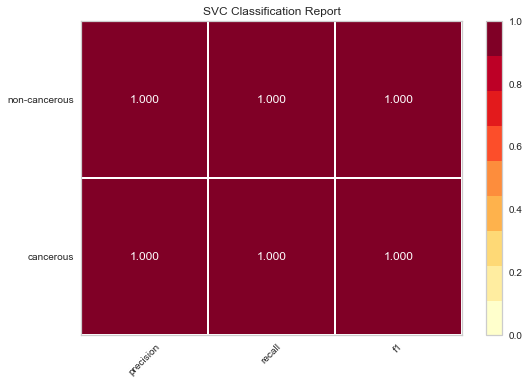

In [40]:
classification_report(svm,X_train, Y_train,X_test, Y_test)

0.8920863309352518


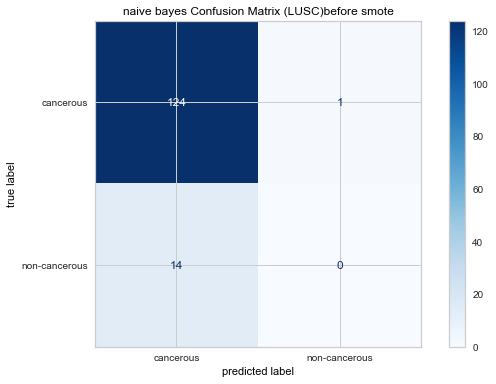

In [41]:
from sklearn.naive_bayes import GaussianNB
# Init the Gaussian Classifier
model = GaussianNB()
CONFUSION_MATRIX(model,x_train,y_train,x_test,y_test,"naive bayes",table1,accuracy,precision,recall,F1,models,'before smote')

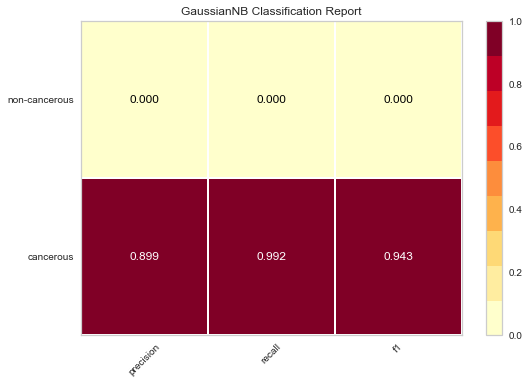

In [42]:
classification_report(model,x_train, y_train,x_test, y_test)

0.9442231075697212


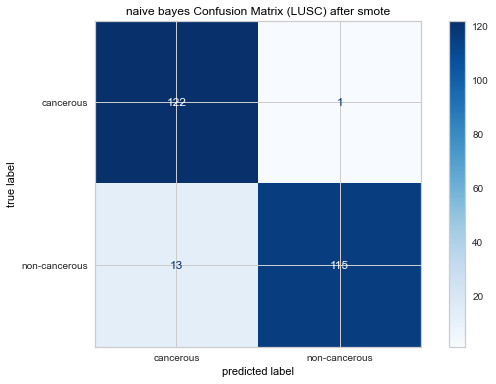

In [43]:
CONFUSION_MATRIX(model,X_train,Y_train,X_test,Y_test,"naive bayes",table2,accuracy1,precision1,recall1,F11,models1,' after smote')

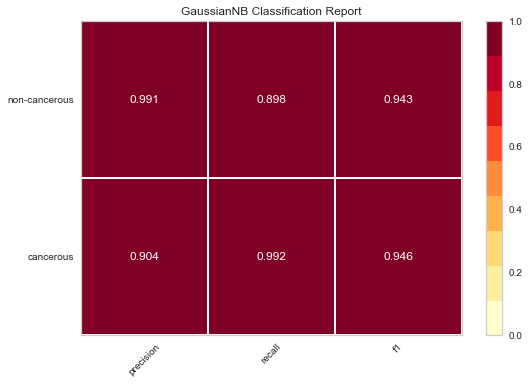

In [44]:
classification_report(model,X_train, Y_train,X_test, Y_test)

0.9928057553956835


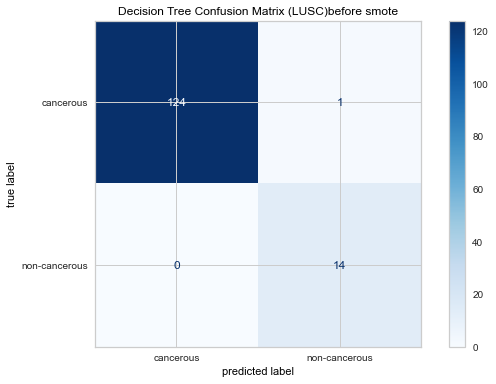

In [23]:
#DECISION TREE CLASSIFIER before hyperparameter tuning
from sklearn.tree import DecisionTreeClassifier  
model= DecisionTreeClassifier(random_state=0) 
CONFUSION_MATRIX(model,x_train,y_train,x_test,y_test,"Decision Tree",table1,accuracy,precision,recall,F1,models,'before smote')


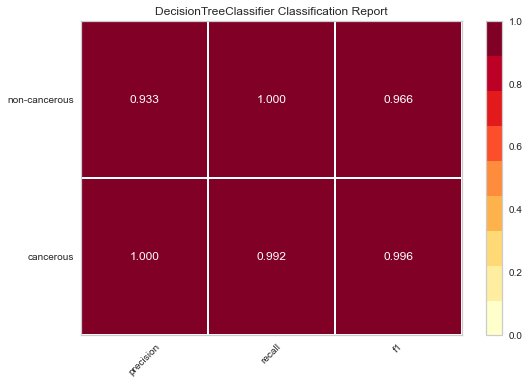

In [24]:
classification_report(model,x_train, y_train,x_test, y_test)

0.9920318725099602


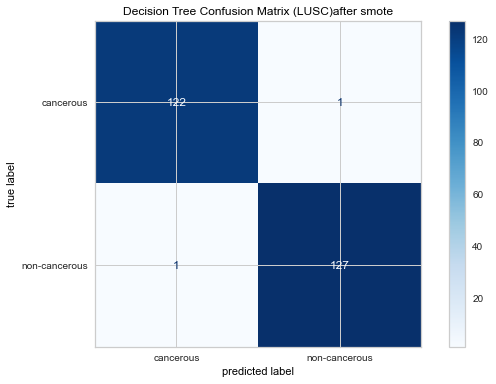

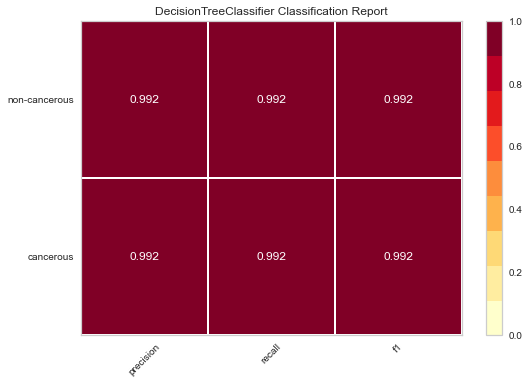

In [26]:
CONFUSION_MATRIX(model,X_train,Y_train,X_test,Y_test,"Decision Tree",table2,accuracy1,precision1,recall1,F11,models1,'after smote')
classification_report(model,X_train, Y_train,X_test, Y_test)

0.9928057553956835


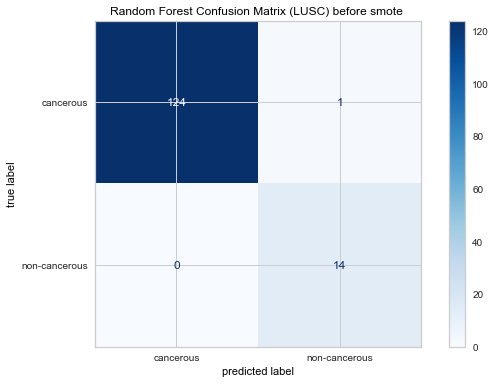

In [48]:
#RANDOM FOREST CLASSIFIER
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=10, random_state=0,)
CONFUSION_MATRIX(clf,x_train,y_train,x_test,y_test,"Random Forest",table1,accuracy,precision,recall,F1,models,' before smote ')


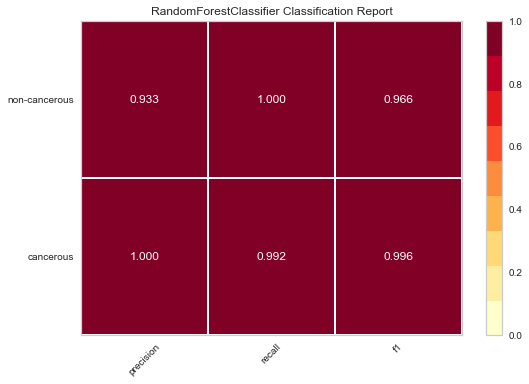

In [49]:
classification_report(clf,x_train, y_train,x_test, y_test)

1.0


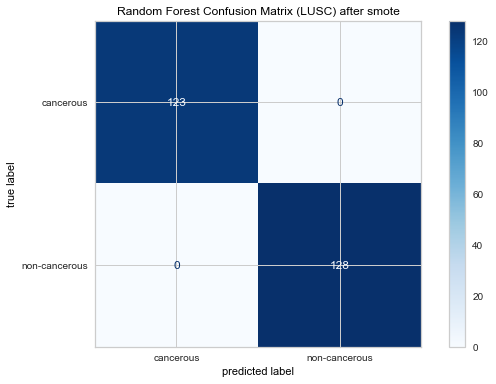

In [50]:
CONFUSION_MATRIX(clf,X_train,Y_train,X_test,Y_test,"Random Forest",table2,accuracy1,precision1,recall1,F11,models1,' after smote')

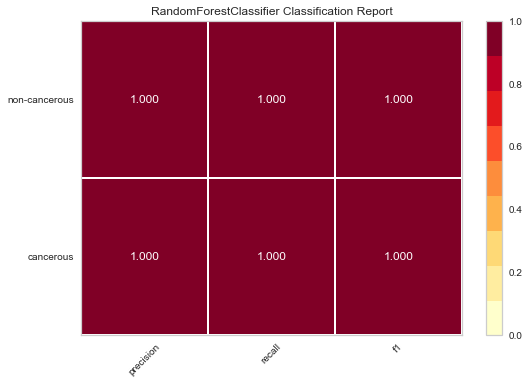

In [51]:
classification_report(clf,X_train, Y_train,X_test, Y_test)

0.9640287769784173


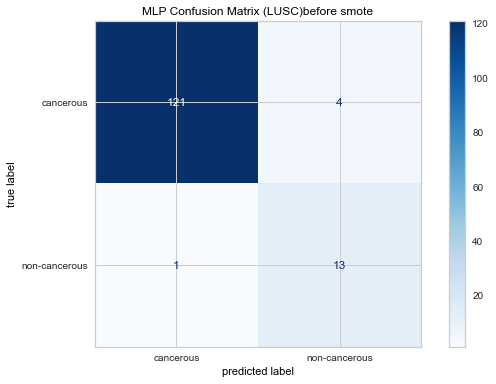

In [52]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='adam',hidden_layer_sizes=(15,), random_state=1,max_iter=500)
CONFUSION_MATRIX(clf,x_train,y_train,x_test,y_test,"MLP",table1,accuracy,precision,recall,F1,models,'before smote')


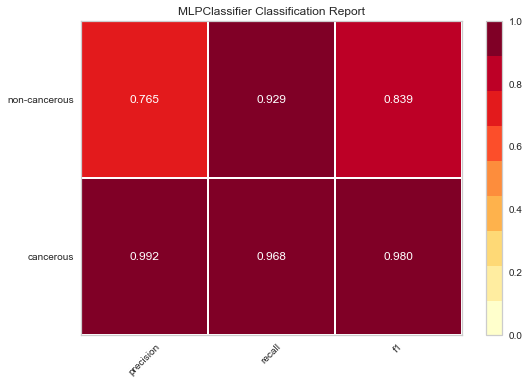

In [53]:
classification_report(clf,x_train, y_train,x_test, y_test)

0.9920318725099602


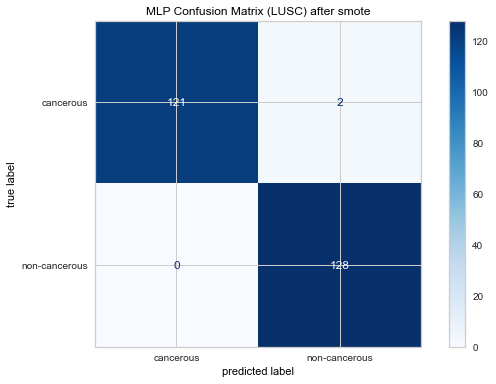

In [54]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='adam',hidden_layer_sizes=(15,), random_state=1,max_iter=500)
CONFUSION_MATRIX(clf,X_train,Y_train,X_test,Y_test,"MLP",table2,accuracy1,precision1,recall1,F11,models1,' after smote')


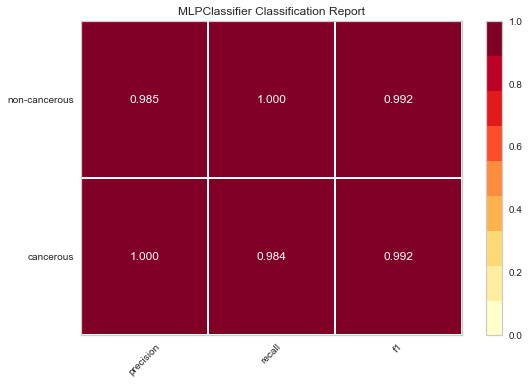

In [55]:
classification_report(clf,X_train, Y_train,X_test, Y_test)

In [56]:
print(table1)

+-----------+-------+---------------------+------------+---------+-------------+---------------+---------------+-------+
|           |  KNN  | Logistic Regression | SVM Linear | SVM RBF | naive bayes | Decision Tree | Random Forest |  MLP  |
+-----------+-------+---------------------+------------+---------+-------------+---------------+---------------+-------+
|    TPR    | 88.49 |         77.7        |   89.93    |  89.93  |    89.21    |     89.21     |     89.21     | 87.05 |
|    TNR    |  9.35 |        10.07        |   10.07    |   7.91  |     0.0     |     10.07     |     10.07     |  9.35 |
|    FPR    |  0.72 |         0.0         |    0.0     |   2.16  |    10.07    |      0.0      |      0.0      |  0.72 |
|    FNR    |  1.44 |        12.23        |    0.0     |   0.0   |     0.72    |      0.72     |      0.72     |  2.88 |
|  Accuracy | 97.84 |        87.77        |   100.0    |  97.84  |    89.21    |     99.28     |     99.28     |  96.4 |
| precision | 97.93 |        94.

In [57]:
print(table2)

+-----------+-------+----------------+------------+---------+-------------+---------------+---------------+-------+
|           |  KNN  | Log Regression | SVM Linear | SVM RBF | naive bayes | Decision Tree | Random Forest |  MLP  |
+-----------+-------+----------------+------------+---------+-------------+---------------+---------------+-------+
|    TPR    | 48.21 |     43.82      |    49.0    |   49.0  |    48.61    |     48.61     |      49.0     | 48.21 |
|    TNR    |  51.0 |      51.0      |    51.0    |   51.0  |    45.82    |      50.6     |      51.0     |  51.0 |
|    FPR    |  0.0  |      0.0       |    0.0     |   0.0   |     5.18    |      0.4      |      0.0      |  0.0  |
|    FNR    |  0.8  |      5.18      |    0.0     |   0.0   |     0.4     |      0.4      |      0.0      |  0.8  |
|  Accuracy |  99.2 |     94.82      |   100.0    |  100.0  |    94.42    |      99.2     |     100.0     |  99.2 |
| precision | 99.22 |      95.3      |   100.0    |  100.0  |    94.84  

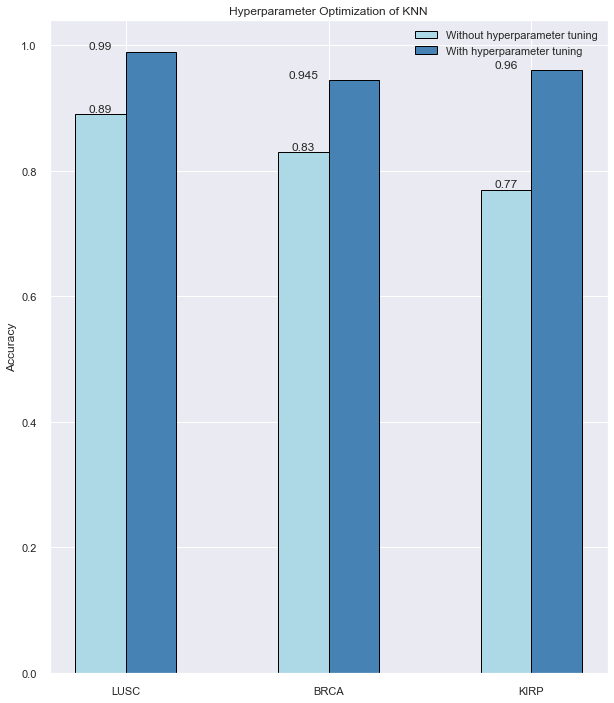

In [183]:

fig = plt.figure(figsize=(10,12))
A=[0.89,0.83,0.77]
B=[0.99,0.945,0.96]
M=['LUSC','BRCA','KIRP']
n=len(A)
width=0.25
r=np.arange(n)
plt.bar(r,A,edgecolor='black',color='lightblue',width=width,label='Without hyperparameter tuning')
plt.bar(r+width,B,edgecolor='black',color='steelblue',width=width,label='With hyperparameter tuning')
sns.set_theme(style="darkgrid")
plt.ylabel("Accuracy")
plt.title("Hyperparameter Optimization of KNN")
plt.xticks(r+ width/2,M)
for i in range(len(A)):
    plt.text(i,A[i],A[i],ha='center',va='bottom')
    plt.text(i,B[i],B[i],ha='center',va='bottom')


plt.legend()
plt.show()

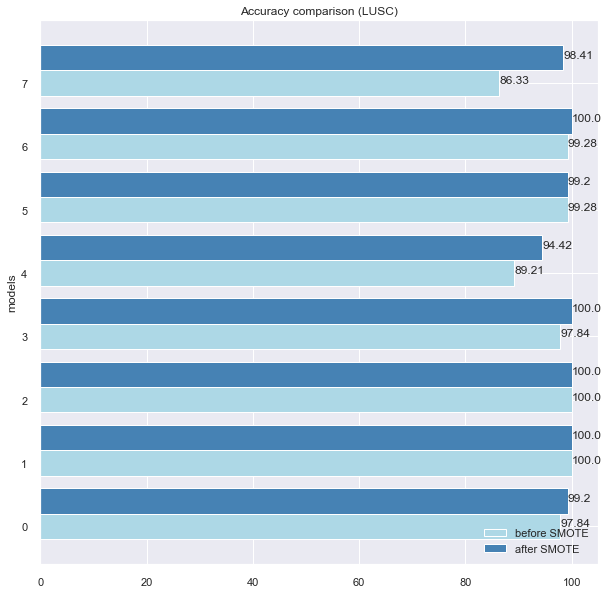

In [174]:
Groups=[accuracy,accuracy1]
height = 0.8 / len(Groups)
Pos = np.array(range(8))

fig = plt.figure(figsize=(10,10))
Colors = ['lightblue', 'steelblue']
for i in range(len(Groups)):
    plt.barh(Pos + i * height, Groups[i], height = height, color = Colors[i], edgecolor = 'white')

    for k in range(len(Groups[0])):
        plt.annotate(Groups[i][k], (Groups[i][k], Pos[k] + i * height))
plt.ylabel("models")
plt.title("Accuracy comparison (LUSC)")

plt.legend(['before SMOTE','after SMOTE'], loc = 'lower right')
plt.show()

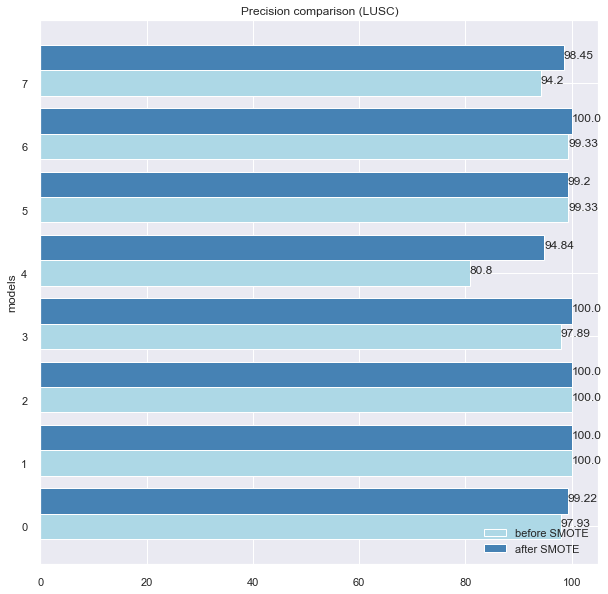

In [175]:
Groups=[precision,precision1]
height = 0.8 / len(Groups)
Pos = np.array(range(8))

fig = plt.figure(figsize=(10,10))
Colors = ['lightblue', 'steelblue']
for i in range(len(Groups)):
    plt.barh(Pos + i * height, Groups[i], height = height, color = Colors[i], edgecolor = 'white')

    for k in range(len(Groups[0])):
        plt.annotate(Groups[i][k], (Groups[i][k], Pos[k] + i * height))
plt.ylabel("models")
plt.title("Precision comparison (LUSC)")

plt.legend(['before SMOTE','after SMOTE'], loc = 'lower right')
plt.show()

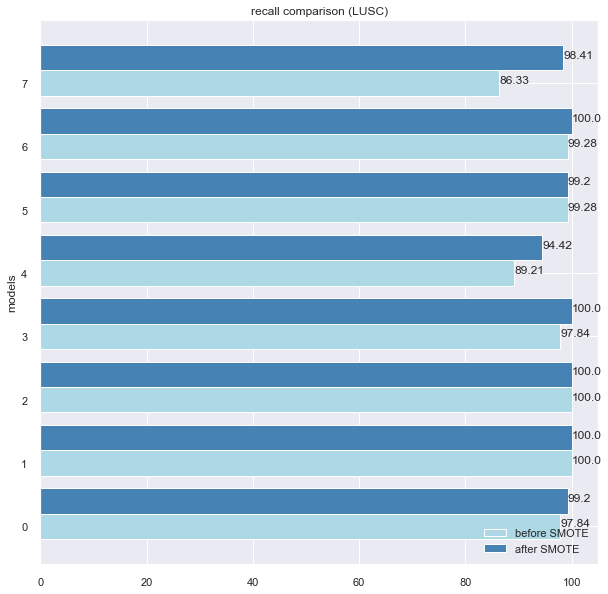

In [176]:
Groups=[recall,recall1]
height = 0.8 / len(Groups)
Pos = np.array(range(8))

fig = plt.figure(figsize=(10,10))
Colors = ['lightblue', 'steelblue']
for i in range(len(Groups)):
    plt.barh(Pos + i * height, Groups[i], height = height, color = Colors[i], edgecolor = 'white')

    for k in range(len(Groups[0])):
        plt.annotate(Groups[i][k], (Groups[i][k], Pos[k] + i * height))
plt.ylabel("models")
plt.title("recall comparison (LUSC)")

plt.legend(['before SMOTE','after SMOTE'], loc = 'lower right')
plt.show()

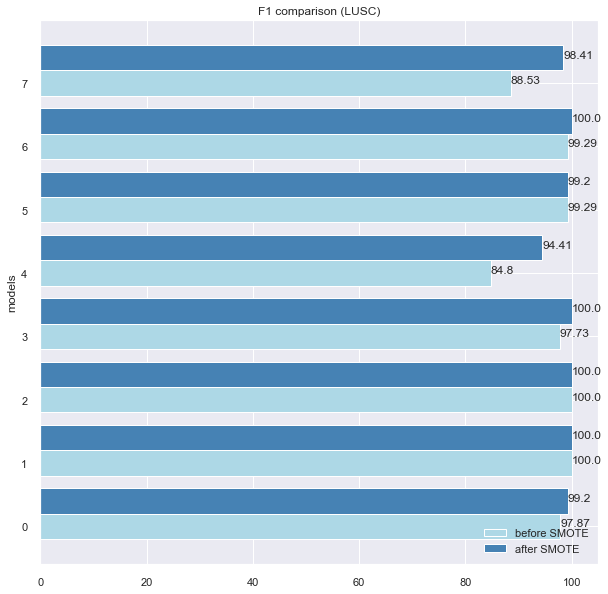

In [177]:
Groups=[F1,F11]
height = 0.8 / len(Groups)
Pos = np.array(range(8))

fig = plt.figure(figsize=(10,10))
Colors = ['lightblue', 'steelblue']
for i in range(len(Groups)):
    plt.barh(Pos + i * height, Groups[i], height = height, color = Colors[i], edgecolor = 'white')

    for k in range(len(Groups[0])):
        plt.annotate(Groups[i][k], (Groups[i][k], Pos[k] + i * height))
plt.ylabel("models")
plt.title("F1 comparison (LUSC)")

plt.legend(['before SMOTE','after SMOTE'], loc = 'lower right')
plt.show()